In [1]:
%matplotlib inline
from __future__ import division, print_function
import sys,os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

sys.path.append(os.path.join(os.getcwd(),'../..'))

import dltk.core.modules as modules
from dltk.models.segmentation.unet import ResUNET
from dltk.models.segmentation.fcn import ResNetFCN
from dltk.core.modules import dice_loss

plt.rcParams['image.cmap'] = 'gray'

imwidth=256
imheight=256
batchSize=5
trainSteps=200
gpusets=(0,1) # GPU numbers to use ie. for devices /gpu:0 and /gpu:1, (0,) behaves like single GPU

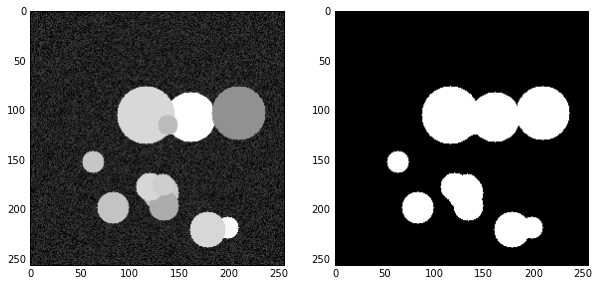

In [2]:
def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,0.25,size=image.shape)
    
    return np.maximum(image,norm),(image>0).astype(float)


def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
im,mask=createTestImage(imwidth,imheight)
plotPair(im,mask)

INFO:tensorflow:(5, 256, 256, 16)
INFO:tensorflow:feat_scale_1 shape (5, 128, 128, 32)
INFO:tensorflow:feat_scale_2 shape (5, 64, 64, 64)
INFO:tensorflow:Building upsampling for scale 1 with x ([5, 64, 64, 64]) x_up ([5, 128, 128, 32]) stride ((2, 2))
INFO:tensorflow:up_1 shape (5, 128, 128, 32)
INFO:tensorflow:Building upsampling for scale 0 with x ([5, 128, 128, 32]) x_up ([5, 256, 256, 16]) stride ((2, 2))
INFO:tensorflow:up_0 shape (5, 256, 256, 16)
INFO:tensorflow:last conv shape (5, 256, 256, 1)
INFO:tensorflow:(5, 256, 256, 16)
INFO:tensorflow:feat_scale_1 shape (5, 128, 128, 32)
INFO:tensorflow:feat_scale_2 shape (5, 64, 64, 64)
INFO:tensorflow:Building upsampling for scale 1 with x ([5, 64, 64, 64]) x_up ([5, 128, 128, 32]) stride ((2, 2))
INFO:tensorflow:up_1 shape (5, 128, 128, 32)
INFO:tensorflow:Building upsampling for scale 0 with x ([5, 128, 128, 32]) x_up ([5, 256, 256, 16]) stride ((2, 2))
INFO:tensorflow:up_0 shape (5, 256, 256, 16)
INFO:tensorflow:last conv shape (5,

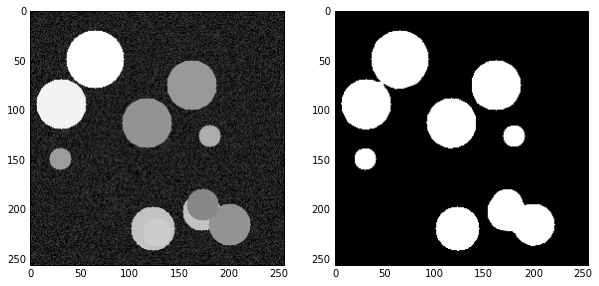

In [3]:
def averageGradients(tower_grads):
    '''This averages the tower gradients into one, copied directly from the Tensorflow MNIST example.'''
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            if g is not None:
                # Add 0 dimension to the gradients to represent the tower.
                expanded_g = tf.expand_dims(g, 0)

                # Append on a 'tower' dimension which we will average over below.
                grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(axis=0, values=grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
        
    return average_grads


def fillTrainData(xt,yt):
    for i in range(batchSize):
        im,mask=createTestImage(imwidth,imheight)
        xt[i,:,:,0]=im
        yt[i,:,:]=mask
        
    
with tf.Graph().as_default(), tf.device('/cpu:0'):
    opt=tf.train.AdamOptimizer(1e-4)
    global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
    
    grads=[]
    xytrain=[]
    losses=[]
    feeddict={}
    
    xtrain=np.zeros((batchSize,imwidth,imheight,1))
    ytrain=np.zeros((batchSize,imwidth,imheight))

    # plug & play network definition:
    # net = ResNetFCN(num_classes=1,num_residual_units=3,
    #              filters=(16, 32, 64),
    #              strides=((1,1), (2,2), (2,2)))

    net = ResUNET(num_classes=1,num_residual_units=3,
                  filters=(16, 32, 64),
                  strides=((1,1), (2,2), (2,2)))
    
    with tf.variable_scope(tf.get_variable_scope()):
        for g in gpusets:
            with tf.device('/gpu:%i'%g),tf.name_scope('tower_%i'%g) as scope:
                xt=np.zeros(xtrain.shape)
                yt=np.zeros(ytrain.shape)
                x=tf.placeholder(tf.float32, xtrain.shape)
                y_=tf.placeholder(tf.int32, ytrain.shape)
                feeddict[x]=xt
                feeddict[y_]=yt
                xytrain.append((xt,yt))           

                y = net(x)['logits']
                loss = dice_loss(y, y_, 1)

                grad=opt.compute_gradients(loss)
                grads.append(grad)
                losses.append(loss)
                
    avggrads=averageGradients(grads)
    
    trainop = opt.apply_gradients(avggrads, global_step=global_step)

    soft_config = tf.ConfigProto(allow_soft_placement=True)
    soft_config.gpu_options.allow_growth = True
    soft_config.log_device_placement=True
    
    with tf.Session(config=soft_config) as sess:
        sess.run(tf.global_variables_initializer())
        
        # perform training steps
        for step in range(trainSteps):
            for xt,yt in xytrain:
                fillTrainData(xt,yt)
                
            trainop.run(feed_dict=feeddict)
            
        # evaluate result with new generated data
        fillTrainData(xtrain,ytrain)
        x=tf.placeholder(tf.float32, xtrain.shape)
        ypred=net(x, is_training=False)['y_']
        test=ypred.eval(feed_dict={x:xtrain})
        
        # plot prediction
        plotPair(np.squeeze(xtrain[0]),test[0])     